# Malaria Detection 

The project aims to use cell images acquired using blood smear tests to build a predictive model for Malaria diagnosis. This model can work in conjunction with traditional microscopy methods to expedite the process of obtaining diagnostic results.

## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import  l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=30,          # Rotate images randomly by up to 30 degrees
    width_shift_range=0.2,      # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Shift images vertically by up to 20% of the height
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.3,             # Apply zoom transformations
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest',        # Fill new pixels with the nearest available pixel
    brightness_range=(0.5, 1.5),  # Adjust brightness of images
    validation_split=0.2        # Specify the validation split here
)

#Data preprocessing
test_datagen = ImageDataGenerator(
    rescale=1./255             # Rescale pixel values to [0, 1]
)

# Define the class indices with labels
class_indices = {
    'Uninfected': 0,
    'Parasitized': 1
}

# Generating training data generator
training_set = train_datagen.flow_from_directory(
    'C:/Users/Chait/Downloads/archive/Malaria Cells/training_set',  # Path to the training dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=220,            # Number of images in each batch
    class_mode='binary',       # For binary classification
    classes=class_indices,     # Use the updated class indices
    subset='training'          # Subset of the data (training portion)
)

# Generating validation data generator
validation_set = train_datagen.flow_from_directory(
    'C:/Users/Chait/Downloads/archive/Malaria Cells/training_set',  # Path to the training dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=50,             # Number of images in each batch
    class_mode='binary',       # For binary classification
    classes=class_indices,     # Use the updated class indices
    subset='validation'        # Subset of the data (validation portion)
)

# Generating testing data generator
test_set = test_datagen.flow_from_directory(
    'C:/Users/Chait/Downloads/archive/Malaria Cells/testing_set',  # Path to the testing dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=150,            # Number of images in each batch
    class_mode='binary',       # For binary classification
    classes=class_indices,     # Use the updated class indices
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


CNN model we are using to develop the model doesn't take care of rotation, scaling, etc., in the images. So data augmentation has been employed to increase the robustness of the model. The dataset is taken from Kaggle, and to access it, click [here](https://www.kaggle.com/datasets/miracle9to9/files1) .

## Building a CNN model

In [3]:
# Create a Sequential model
model = Sequential([
    # First Convolutional layer
    Conv2D(filters=16, kernel_size=(3, 3), input_shape=(64, 64, 3)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Second Convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Third Convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Fourth Convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    Flatten(),  # Flatten feature maps to 1D
    Dense(32, activation = "relu"), # Fully connected layer with 32 neurons and ReLU activation
    Dense(16, activation = "relu"), # Fully connected layer with 16 neurons and ReLU activation
    Dense(1, activation='sigmoid')  # Fully connected layer for binary classification
])

This model is designed for detecting malaria. It consists of four convolutional layers, each using Rectified Linear Unit (ReLU) activation functions to introduce nonlinearity. The input data has a shape of (64, 64, 3). The convolutional layers employ ascending numbers of filters: 16, 32, 64, and 128 respectively. To accelerate training and serve as a regularizer, the Batch Normalization technique is utilized. Additionally, L2 regularization is employed to enhance generalization and mitigate overfitting. After the convolutional layers, the data is flattened and passed through a Deep Neural Network (DNN). The initial two layers of the DNN facilitate the learning of intricate data relationships. Finally, the output layer employs a sigmoid activation function to achieve binary classification.

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 32)        1

## Model Compiling and Training

The model is compiled using the Adam optimizer, with a binary_crossentropy loss function and the following metrics: accuracy, precision, recall, and AUC. A learning rate reduction callback (ReduceLROnPlateau) is defined to decrease the learning rate when validation loss plateaus. The monitor parameter tracks 'val_loss', reducing the learning rate by a factor of 0.2 after a patience of 2 epochs, and providing verbose updates.

In [5]:
# Compiling the model with Adam optimizer and metrics including accuracy and precision
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Define a callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train the model using the training set and validate using the validation set
history = model.fit(training_set, epochs=20, validation_data=validation_set, callbacks=[reduce_lr])

Epoch 1/20
101/101 [==============================] - 344s 3s/step - loss: 1.3264 - accuracy: 0.6943 - precision: 0.7044 - recall: 0.6694 - auc: 0.7736 - val_loss: 1.0712 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6838 - lr: 0.0010
Epoch 2/20
101/101 [==============================] - 75s 745ms/step - loss: 0.4901 - accuracy: 0.8934 - precision: 0.9434 - recall: 0.8370 - auc: 0.9404 - val_loss: 1.6039 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4075 - lr: 0.0010
Epoch 3/20
101/101 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.9106 - precision: 0.9514 - recall: 0.8653 - auc: 0.9522
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
101/101 [==============================] - 72s 711ms/step - loss: 0.3529 - accuracy: 0.9106 - precision: 0.9514 - recall: 0.8653 - auc: 0.9522 - val_loss: 1.4877 - val_accuracy: 0.5005 - val_precision: 1.0000 - val_rec

## Accuracy and Loss Graphs

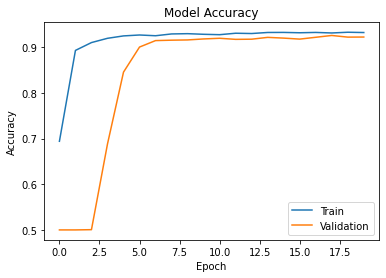

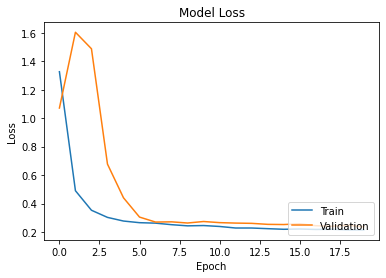

In [6]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#Adding title and labels to x and y axis
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#Adding title and labels to x and y axis
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Evaluating the test set

In [7]:
loss,accuracy,precision,recall,auc = model.evaluate(test_set)

106/106 [==============================] - 184s 2s/step - loss: 0.1563 - accuracy: 0.9563 - precision: 0.9660 - recall: 0.9463 - auc: 0.9889


In [8]:
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test precision: {precision:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

Test accuracy: 0.9563
Test precision: 0.9660
Test recall: 0.9463
Test AUC: 0.9889


## Saving model for web application development

In [9]:
model.save('model.h5')

C:\Users\Chait\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
